In [292]:
import urllib
import MeCab
import gensim
import math
import matplotlib
import matplotlib.pylab as plt
from wordcloud import WordCloud

In [293]:
# テキストファイルのパス
text_path = './simple_input/input_data.tsv'

# 形態素解析用のストップワードの定義
req = urllib.request.Request('http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt')
with urllib.request.urlopen(req) as res:
    stopwords = res.read().decode('utf-8').split('\r\n')
while '' in stopwords:
    stopwords.remove('')

In [294]:
# 形態素解析用の関数定義。固有名詞、名詞、動詞、形容詞を中心に
def analyzer(text, mecab, stopwords=[], target_part_of_speech=['proper_noun', 'noun', 'verb', 'adjective']):

    node = mecab.parseToNode(text)
    words = []

    while node:

        features = node.feature.split(',')
        surface = features[6]

        if (surface == '*') or (len(surface) < 2) or (surface in stopwords):
            node = node.next
            continue

        noun_flag = (features[0] == '名詞')
        proper_noun_flag = (features[0] == '名詞') & (features[1] == '固有名詞')
        verb_flag = (features[0] == '動詞') & (features[1] == '自立')
        adjective_flag = (features[0] == '形容詞') & (features[1] == '自立')


        if ('proper_noun' in target_part_of_speech) & proper_noun_flag:
            words.append(surface)
        elif ('noun' in target_part_of_speech) & noun_flag:
            words.append(surface)
        elif ('verb' in target_part_of_speech) & verb_flag:
            words.append(surface)
        elif ('adjective' in target_part_of_speech) & adjective_flag:
            words.append(surface)

        node = node.next

    return words

In [423]:
# LDAのための辞書とコーパス作成
mecab = MeCab.Tagger('-d /usr/local/lib/mecab/dic/ipadic')

text = open(text_path, 'r', encoding='utf-8').read()

texts_words = {}
text = text.split('\n')
# text = text.replace('\n', '。')
# text = text.split('。')
for i, t in enumerate(text):
    texts_words[i] = [w for w in analyzer(t, mecab, stopwords=stopwords, target_part_of_speech=['noun', 'proper_noun'])]

dictionary = gensim.corpora.Dictionary(texts_words.values())
dictionary.filter_extremes(no_below=2, no_above=0.6)
#dictionary.filter_n_most_frequent(4)
corpus = [dictionary.doc2bow(words) for words in texts_words.values()]

In [380]:
# # LDAのための辞書とコーパス作成
# mecab = MeCab.Tagger('-d /usr/local/lib/mecab/dic/ipadic')

# text = open(text_path, 'r', encoding='utf-8').read()

# texts = []
# text = text.split('\n')
# for t in text:
#     texts.append(analyzer(t, mecab, stopwords=stopwords, target_part_of_speech=['noun', 'proper_noun']))

# dictionary = gensim.corpora.Dictionary(texts)
# dictionary.filter_extremes(no_below=3, no_above=0.5)
# corpus = [dictionary.doc2bow(t) for t in texts]

In [390]:
# LDAのための辞書とコーパス作成
mecab = MeCab.Tagger('-d /usr/local/lib/mecab/dic/ipadic')

text = open(text_path, 'r', encoding='utf-8').read()
text = text.split('\n')
# text = ' '.join(text)
words = analyzer(' '.join(text), mecab, stopwords=stopwords, target_part_of_speech=['noun', 'proper_noun'])

dictionary = gensim.corpora.Dictionary([words])
# dictionary.filter_extremes(no_below=0, no_above=0.5, keep_n=100000)
dictionary.filter_n_most_frequent(10)
# corpus = [dictionary.doc2bow([w]) for w in words]
corpus = [dictionary.doc2bow([w]) for w in words]

In [403]:
len(dictionary)

3813

In [404]:
len(corpus)

3364

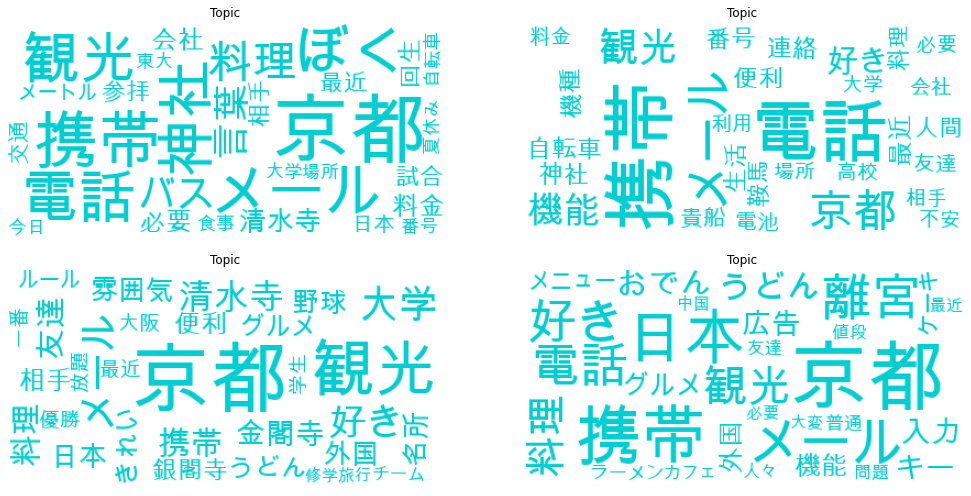

In [424]:
# LDAの実行
num_topics = 4
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=0)

# 可視化
FONT = "./ArialUnicodeMS.ttf"
ncols = math.ceil(num_topics/2)
nrows = math.ceil(lda_model.num_topics/ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,7))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i in range(lda_model.num_topics):

    x = dict(lda_model.show_topic(i, 30))
    im = WordCloud(
        font_path=FONT,
        background_color='white',
        color_func=color_func,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t))

plt.tight_layout()
plt.savefig("./visualize.png")